# Recording

> Storing data

In [1]:
#|default_exp augmentation

In [2]:
#|hide
%load_ext autoreload
%autoreload 2

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from AIsaac.utils import *
from AIsaac.dataloaders import *
from AIsaac.models import *
from AIsaac.initialization import *
from AIsaac.trainer import *
from AIsaac.training import *
from AIsaac.recording import *
from AIsaac.visualization import *
from AIsaac.cb_groups import *

from datetime import datetime, timedelta
import torchvision.transforms.functional as TF,torch.nn.functional as F
import math, time

import matplotlib.pyplot as plt
import matplotlib as mpl
import fastcore.all as fc
import torch
from torch import nn, Tensor
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import pandas as pd , numpy as np
from torcheval.metrics import MulticlassAccuracy,Mean
from torch.optim.lr_scheduler import ExponentialLR

import dill as pickle
from fastprogress.fastprogress import master_bar, progress_bar
import inspect
import torchinfo
from torchvision import transforms
from itertools import zip_longest

/home/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#|hide
import logging

In [6]:
#|hide
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
# mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

set_seed(42)


In [7]:
xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]

_dataset = load_dataset('fashion_mnist').with_transform(transformi)

100%|██████████| 2/2 [00:00<00:00, 507.20it/s]


In [8]:
dls = DataLoaders.from_dataset_dict(_dataset, 256, num_workers=4)

In [9]:
#| export
class BatchAugmentationCB(Callback):
    def __init__(self,tfms): self.tfms = fc.L(tfms)
    def before_batch(self,trainer):
        '''applies tfms in tfms list to appropriate items in batch'''
        trainer.batch = fc.L(tfm(item) for tfm,item in zip_longest(self.tfms,trainer.batch,fillvalue=fc.noop))

In [10]:
#| export
class UnNormalize:
    def __init__(self, mean, std): fc.store_attr()
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std): t.mul_(s).add_(m)
        return tensor

In [11]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Trainer, max_n=9, callbacks=None, **kwargs):
    self.fit(1, callbacks=[OneBatchCB()]+fc.L(callbacks))
    show_images(self.batch[0][:max_n], **kwargs)

In [12]:
tfms = [torch.nn.Sequential(transforms.RandomVerticalFlip(1),transforms.RandomErasing(1))]
trainer = Trainer(dls,
                  nn.CrossEntropyLoss(), 
                  torch.optim.Adam, 
                  get_model_conv(),
                  callbacks=[BasicTrainCB(),DeviceCB(),BatchAugmentationCB(tfms)])

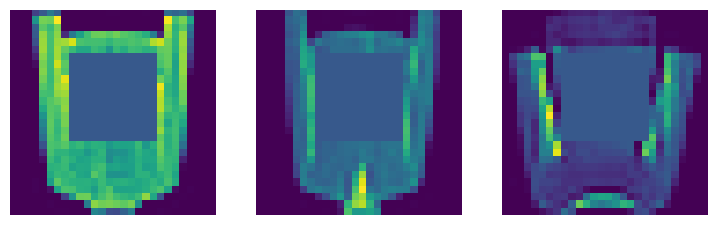

In [13]:
trainer.show_image_batch(3)

In [14]:
#| hide
import nbdev; nbdev.nbdev_export()